# Train cellpose model with segmented images

by Felix Romer

last changed: 05.12.2024

## Package import


In [ ]:
# Data manipulation and analysis
import numpy as np
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# File handling
import os
import tifffile as tiff

# Image processing
from cellpose import io, models, train
from sklearn.model_selection import train_test_split 
from skimage import measure, segmentation

io.logger_setup()

2024-12-04 14:49:07,376 [INFO] WRITING LOG OUTPUT TO /home/felix/.cellpose/run.log
2024-12-04 14:49:07,377 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.9.20 
torch version:  	2.5.1+cu124


## Set parameters

In [ ]:

# Directory containing your segmented images (*.npy) and raw data (*.tif)
data_dir = "/path/to/your/data"  # Change this to your data directory
all_files = os.listdir(data_dir)

# Load raw images and segmentation masks
image_files = sorted([os.path.join(data_dir, f) for f in all_files if not f.endswith('_seg.npy') and not f.endswith('_masks.png') and not f.endswith('_edges.tif')])
mask_files = sorted([os.path.join(data_dir, f) for f in all_files if f.endswith('_seg.npy')])
edge_files = sorted([os.path.join(data_dir, f) for f in all_files if f.endswith('_edges.tif')])

# Ensure the lists of images and masks match in length
assert len(image_files) == len(mask_files), "Mismatch between image and mask files."

# Split into training and testing datasets
train_images, test_images, train_masks, test_masks, train_edges, test_edges = train_test_split(
    image_files, mask_files, edge_files, test_size=0.2, random_state=42
)


train_data = [io.imread(f) for f in train_images]
train_labels = [io.imread(f) for f in train_masks]
train_edges = [io.imread(f) for f in train_edges]

test_data = [io.imread(f) for f in test_images]
test_labels =[io.imread(f) for f in test_masks]
test_edges = [io.imread(f) for f in test_edges]

## Train model

In [ ]:
# I used the Cellpose model type "cyto3" for cytoplasm segmentation as base model
model = models.CellposeModel(model_type="cyto3")
model_path, train_losses, test_losses = train.train_seg(model.net,
                            train_data=train_data, train_labels=train_labels,
                            channels=[None, None], normalize=True,
                            test_data=test_data, test_labels=test_labels,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=100, model_name="my_new_model")
print(f"Model saved to {str(model_path)}")

### Load the trained model and the ground trouth model

In [ ]:

model = models.CellposeModel(pretrained_model=str(model_path))
second_model = models.CellposeModel(model_type="cyto3")


2024-12-04 14:02:08,629 [INFO] >>>> using CPU
2024-12-04 14:02:08,633 [INFO] >>>> using CPU
2024-12-04 14:02:08,730 [INFO] >>>> loading model /media/felix/Felixdrive/Coding/Cellpose/models/my_new_model
2024-12-04 14:02:08,840 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-12-04 14:02:08,841 [INFO] >>>> model diam_labels =  106.348 (mean diameter of training ROIs)
2024-12-04 14:02:08,845 [INFO] >> cyto3 << model set to be used
2024-12-04 14:02:08,846 [INFO] >>>> using CPU
2024-12-04 14:02:08,846 [INFO] >>>> using CPU
2024-12-04 14:02:08,929 [INFO] >>>> loading model /home/felix/.cellpose/models/cyto3


/home/felix/miniconda3/envs/cellpose_env/lib/python3.9/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file

2024-12-04 14:02:09,072 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


### Get boundaries

In [ ]:
# Predict segmentations on test images
predicted_masks = []
boundaries = []
gt_boundaries = []

predicted_masks_cyto3 = []
boundaries_cyto3 = []
gt_boundaries = []
for img in test_data:
    # Load predicted boundaries
    masks, _, _ = model.eval(
        img,
        channels=[None, None],  # Single-channel images
        normalize=True          # Normalize images
    )
    predicted_masks.append(masks)
    boundaries.append(segmentation.find_boundaries(masks, mode='thick'))

    # Load ground truth boundaries
    masks, _, _ = second_model.eval(
        img,
        channels=[None, None],  # Single-channel images
        normalize=True          # Normalize images
    )
    predicted_masks_cyto3.append(masks)
    boundaries_cyto3.append(segmentation.find_boundaries(masks, mode='thick'))


### Visulaize the results   

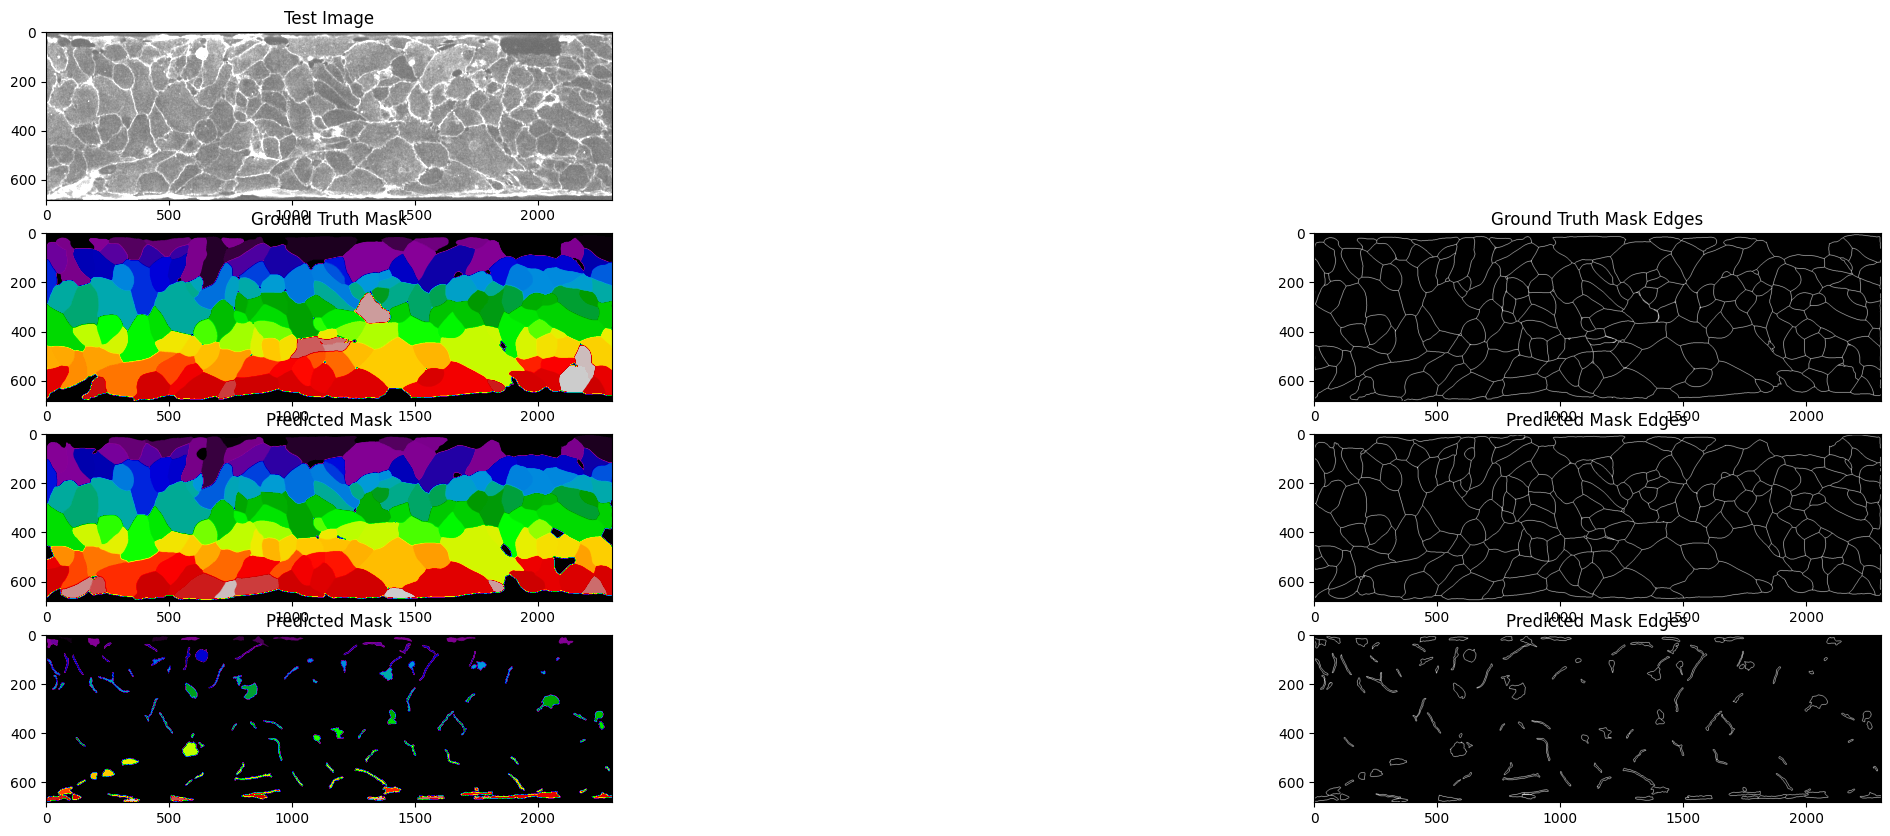

In [ ]:
# Visualize a test image, ground truth, and prediction
index = 1  # Change this index to view different examples
plt.figure(figsize=(30, 10))

plt.subplot(4, 2, 1)
plt.imshow(test_data[index], cmap='gray', vmin=0, vmax=255)
plt.title('Test Image')

plt.subplot(4, 2, 3)
plt.imshow(test_labels[index], cmap='nipy_spectral')
plt.title('Ground Truth Mask')

plt.subplot(4, 2, 5)
plt.imshow(predicted_masks[index], cmap='nipy_spectral')
plt.title('Predicted Mask')

plt.subplot(4, 2, 7)
plt.imshow(predicted_masks_cyto3[index], cmap='nipy_spectral')
plt.title('Predicted Mask')

# Plot edges on the ground truth mask
plt.subplot(4, 2,4)
plt.imshow(test_edges[index], cmap='gray')
plt.title('Ground Truth Mask Edges')

# Plot edges on the predicted mask
plt.subplot(4, 2, 6)
plt.imshow(boundaries[index], cmap='gray')
plt.title('Predicted Mask Edges')

# Plot edges on the predicted mask
plt.subplot(4, 2, 8)
plt.imshow(boundaries_cyto3[index], cmap='gray')
plt.title('Predicted Mask Edges')

plt.show()
